In [1]:
from qiskit.circuit import Parameter
from qiskit import QuantumCircuit
import random
import math
import numpy as np
import matplotlib.pyplot as plt

from helper_functions_tsp import read_file_name, validate_distance_array
from helper_functions_tsp import find_problem_size, find_stats

In [15]:
LOCATIONS = 10                #number of locations to be visited
VERBOSE = False               #controls how much is printed
TOLERANCE = 1e-2              #Tolerance
#RELEVANT_VALUES = 50         #controls how many of the items to average over as a percentage
                              #eg 100 = all 
                              #30 = top 30%
#LEARNING_RATE = 1e-2         #learning rate
#UPDATES = 100                #updates, or iterations
#PRINT_FREQUENCY = 20         #how often results are printed out
#SPSA = False                 #SPSA stochastic gradient descent used
#DEBUG = False                #Extra data printed out

From the number of locations visited find the qubits and longest binary string.

In [16]:
bin_len, qubits = find_problem_size(LOCATIONS)
print(f'There are {qubits} qubits needed.  The longest binary string is {bin_len}')

There are 21 qubits needed.  The longest binary string is 4


Data sources are held locally to avoid downstream dependencies.

In [4]:
data_sources = {  4 : {'file' : 'data/four_d.txt'},
                  5 : {'file' : 'data/five_d.txt'},
                 15 : {'file' : 'data/p01_d.txt'},
                 17 : {'file' : 'data/gr17_d.txt'},
                 26 : {'file' : 'data/fri26_d.txt'},
                 42 : {'file' : 'data/dantzig42_d.txt'},
                 48 : {'file' : 'data/att48_d.txt'}
                }

filename = read_file_name(LOCATIONS, data_sources)
print(f'Data will be read from filename {filename}')

Data will be read from filename data/p01_d.txt


In [5]:
# may not be needed.
#from qiskit_algorithms.optimizers import COBYLA

Read and validate the distance array.  This checks the array is the correct shape, and is symmetric.

In [6]:
distance_array = np.genfromtxt(filename)
validate_distance_array(distance_array, LOCATIONS)

In [7]:
def initialise_parameters(qubits):
    #initialise parameter text
    init_params = []
    for i in range(qubits):
        text1 = "weight" + str(2*i)
        text2 = "weight" + str(2*i +1 )
        init_params.append(Parameter(text1 ))
        init_params.append(Parameter(text2 ))
    #initialise parameters with random weights    
    for i in range(qubits * 2):
        init_params[i] = random.random() * 2 * math.pi
        if VERBOSE:
            print(init_params[i])
    return init_params

In [8]:
def vqc_circuit(qubits, params):
    #set up a variational quantum circuit
    qc = QuantumCircuit(qubits)
    for i in range(qubits):
        qc.h(i)
        qc.ry(params[2*i], i)
        qc.rx(params[2*i+1], i)
    for i in range(qubits-1):
            qc.cx(i,i+1)
    qc.measure_all()
    return qc

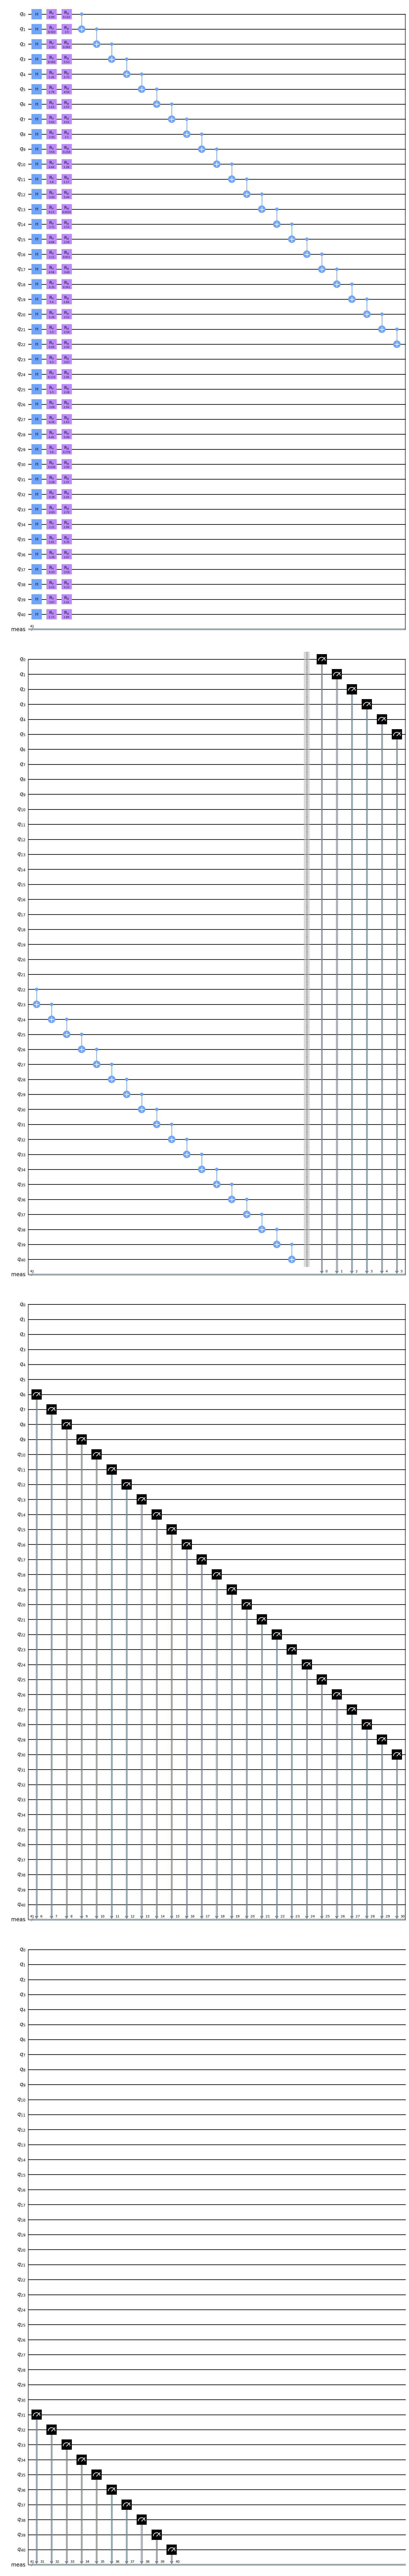

In [9]:
from qiskit_aer.primitives import SamplerV2
#from qiskit_aer.primitives import SamplerV1
#from qiskit.primitives import SamplerV2

sampler = SamplerV2()
#sampler = SamplerV1()
#SHOTS = 1000
SHOTS = 1024

init_params = initialise_parameters(qubits)

#calculate and draw first circuit
qc = vqc_circuit(qubits, init_params)

#draw the first circuit
qc.draw("mpl", style="clifford")

In [10]:
qc = vqc_circuit(qubits, init_params)
job = sampler.run([qc], shots=SHOTS)
results = job.result()
counts = results[0].data.meas.get_counts()
print(counts)
cost, lowest = find_stats(counts, LOCATIONS, distance_array, SHOTS, VERBOSE)
print(cost, lowest)

Simulation failed and returned the following error message:
ERROR:  [Experiment 0] Insufficient memory to run circuit circuit-167 using the statevector simulator. Required memory: 33554432M, max memory: 16111M


ValueError: could not broadcast input array from shape (0,6) into shape (1024,6)

In [ ]:
def cost_func_evaluate(params):
    qc2 = vqc_circuit(qubits, params)
    job = sampler.run([qc2])
    results = job.result()
    counts = results[0].data.meas.get_counts()
    if VERBOSE:
        print(counts)
    cost, lowest = find_stats(counts, LOCATIONS, distance_array, SHOTS)
    graph_list.append([cost, lowest])
    #print(cost, lowest)
    return(cost)

In [ ]:
from scipy.optimize import minimize

In [ ]:
graph_list = []
result = minimize(
    cost_func_evaluate,
    init_params,
    method="COBYLA",
    tol=TOLERANCE
    )

In [ ]:
arr = np.array(graph_list)
n = len(graph_list)
av = arr[:,0]
low = arr[:,1]
x = np.linspace(1, n, num=n)

In [ ]:
import matplotlib.pyplot as plt
plt.style.use('_mpl-gallery')

plt.plot(x, av, linewidth=1.0)
plt.step(x, low, linewidth=1.0)
# plot
plt.grid(axis='x', color='0.95')
plt.title('Average distance and lowest distance found')
plt.show()
